In [2]:
# Install imageio for creating animations.
!pip -q install imageio
!pip -q install scikit-image
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-8zakrtib
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-8zakrtib
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0b5444f1e1b8daca03df9d65ce6ef50a8ef4eba62_-py3-none-any.whl size=154387 sha256=7a6fce62a3bcb1f6dbd19c639141d1cf8dcdde52eeb2b4bef3644012ef16158f
  Stored in directory: /tmp/pip-ephem-wheel-cache-9q_i_8d7/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Failed to build tensorflow-docs
    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [3]:
from absl import logging

import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np


In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import time

try:
  from google.colab import files
except ImportError:
  pass

from IPython import display
from skimage import transform  

In [16]:
# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1. 
# Then interpolates between the two vectors on the hypersphere
latent_dims=512
def interpolate_hypersphere(v1,v2,num_steps):
  v1_norm=tf.norm(v1)
  v2_norm=tf.norm(v2)
  v2_normalised=v2*(v1_norm/v2_norm)

  vectors=[]
  for step in range(num_steps):
    interpolated=v1+(v2_normalised-v1)*step/(num_steps-1)
    interpolated_norm=tf.norm(interpolated)
    interpolated_normalized=interpolated*(v1_norm/interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)  

In [6]:
# Simple way to display an image.
def display_image(image):
  image=tf.constant(image)
  image=tf.image.convert_image_dtype(image, tf.uint8)
  return PIL.Image.fromarray(image.numpy())

In [18]:
# Given a set of images, show an animation.
def animate(images):
  images=np.array(images)
  converted_images=np.clip(images*255,0,255).astype(np.uint8)
  imageio.mimsave('./animation.gif',converted_images)
  return embed.embed_file('./animation.gif')

logging.set_verbosity(logging.ERROR)  

In [13]:
program = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']


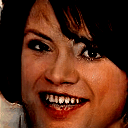

In [19]:
def interpolate_between_vectors():
  v1 = tf.random.normal([latent_dims])
  v2 = tf.random.normal([latent_dims])

  # Creates a tensor with 25 steps of interpolation between v1 and v2.
  vectors = interpolate_hypersphere(v1, v2, 50)

  # Uses module to generate images from the latent space.
  interpolated_images = progan(vectors)['default']

  return interpolated_images

interpolated_images = interpolate_between_vectors()
animate(interpolated_images)

## Finding closest vector in latent space
Fix a target image. As an example use an image generated from the module or upload your own.

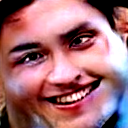

In [21]:
image_from_module_space=True
def get_module_space_image():
  vector = tf.random.normal([1, latent_dims])
  images = progan(vector)['default'][0]
  return images

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[list(uploaded.keys())[0]])
  return transform.resize(image, [128, 128])

if image_from_module_space:
  target_image = get_module_space_image()
else:
  target_image = upload_image()

display_image(target_image)

After defining a loss function between the target image and the image generated by a latent space variable, we can use gradient descent to find variable values that minimize the loss.

In [23]:
tf.random.set_seed(42)
initial_vector = tf.random.normal([1, latent_dims])

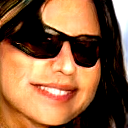

In [24]:
display_image(progan(initial_vector)['default'][0])

In [26]:
def find_closest_latent_vector(initial_vector, num_optimization_steps,
                               steps_per_image):
  images = []
  losses = []

  vector = tf.Variable(initial_vector)  
  optimizer = tf.optimizers.Adam(learning_rate=0.01)
  loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")

  for step in range(num_optimization_steps):
    if (step % 100)==0:
      print()
    print('.', end='')
    with tf.GradientTape() as tape:
      image = progan(vector.read_value())['default'][0]
      if (step % steps_per_image) == 0:
        images.append(image.numpy())
      target_image_difference = loss_fn(image, target_image[:,:,:3])
      # The latent vectors were sampled from a normal distribution. We can get
      # more realistic images if we regularize the length of the latent vector to 
      # the average length of vector from this distribution.
      regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dims))

      loss = target_image_difference + regularizer
      losses.append(loss.numpy())
    grads = tape.gradient(loss, [vector])
    optimizer.apply_gradients(zip(grads, [vector]))

  return images, losses


num_optimization_steps=200
steps_per_image=5
images, loss = find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image)


....................................................................................................
....................................................................................................

(0.0, 6716.37691040039)

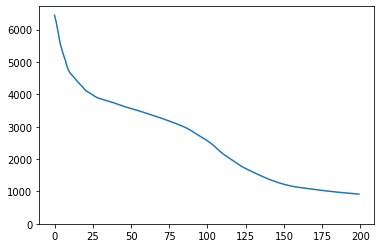

In [27]:
plt.plot(loss)
plt.ylim([0,max(plt.ylim())])


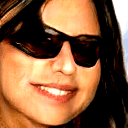

In [28]:
animate(np.stack(images))

#### Compare the result to the target:

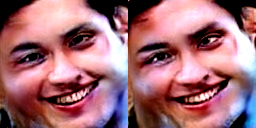

In [29]:
display_image(np.concatenate([images[-1], target_image], axis=1))